<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W4/ungraded_labs/C3_W4_Lab_2_irish_lyrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Generating Text from Irish Lyrics

In the previous lab, you trained a model on just a single song. You might have found that the output text can quickly become gibberish or repetitive. Even if you tweak the hyperparameters, the model will still be limited by its vocabulary of only 263 words. The model will be more flexible if you train it on a much larger corpus and that's what you'll be doing in this lab. You will use lyrics from more Irish songs then see how the generated text looks like. You will also see how this impacts the process from data preparation to model training. Let's get started!

## Imports

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Building the Word Vocabulary

You will first download the lyrics dataset. These will be from a compilation of traditional Irish songs and you can see them [here](https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C3/W4/misc/Laurences_generated_poetry.txt).

In [2]:
!pip install gdown==5.1.0

In [3]:
# Download the dataset
!gdown --id 15UqmiIm0xwh9mt0IYq2z3jHaauxQSTQT

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=15UqmiIm0xwh9mt0IYq2z3jHaauxQSTQT
To: /content/irish-lyrics-eof.txt
100% 69.0k/69.0k [00:00<00:00, 86.1MB/s]


Next, you will lowercase and split the plain text into a list of sentences:

In [4]:
# Load the dataset
data = open('./irish-lyrics-eof.txt').read()

# Lowercase and split the text
corpus = data.lower().split("\n")

# Preview the result
print(corpus)

['come all ye maidens young and fair', 'and you that are blooming in your prime', 'always beware and keep your garden fair', 'let no man steal away your thyme', 'for thyme it is a precious thing', 'and thyme brings all things to my mind', 'nlyme with all its flavours, along with all its joys', 'thyme, brings all things to my mind', 'once i and a bunch of thyme', 'i thought it never would decay', 'then came a lusty sailor', 'who chanced to pass my way', 'and stole my bunch of thyme away', 'the sailor gave to me a rose', 'a rose that never would decay', 'he gave it to me to keep me reminded', 'of when he stole my thyme away', 'sleep, my child, and peace attend thee', 'all through the night', 'guardian angels god will send thee', 'soft the drowsy hours are creeping', 'hill and dale in slumber sleeping', 'i my loving vigil keeping', 'while the moon her watch is keeping', 'while the weary world is sleeping', 'oer thy spirit gently stealing', 'visions of delight revealing', 'breathes a pure 

From here, you can initialize the `Tokenizer` class and generate the word index dictionary:

In [5]:
# Initialize the Tokenizer class
tokenizer = Tokenizer()

# Generate the word index dictionary
tokenizer.fit_on_texts(corpus)

# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')

word index dictionary: {'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'thro

## Preprocessing the Dataset

Next, you will generate the inputs and labels for your model. The process will be identical to the previous lab. The `xs` or inputs to the model will be padded sequences, while the `ys` or labels are one-hot encoded arrays.

In [6]:
# Initialize the sequences list
input_sequences = []

# Loop over every line
for line in corpus:

	# Tokenize the current line
	token_list = tokenizer.texts_to_sequences([line])[0]

	# Loop over the line several times to generate the subphrases
	for i in range(1, len(token_list)):

		# Generate the subphrase
		n_gram_sequence = token_list[:i+1]

		# Append the subphrase to the sequences list
		input_sequences.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])

# Pad all sequences
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

You can then print some of the examples as a sanity check.

In [7]:
# Get sample sentence
sentence = corpus[0].split()
print(f'sample sentence: {sentence}')

# Initialize token list
token_list = []

# Look up the indices of each word and append to the list
for word in sentence:
  token_list.append(tokenizer.word_index[word])

# Print the token list
print(token_list)

sample sentence: ['come', 'all', 'ye', 'maidens', 'young', 'and', 'fair']
[51, 12, 96, 1217, 48, 2, 69]


In [8]:
# Pick element
elem_number = 5

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [   0    0    0    0    0    0    0    0    0   51   12   96 1217   48
    2]
decoded to text: ['come all ye maidens young and']
one-hot label: [0. 0. 0. ... 0. 0. 0.]
index of label: 69


In [9]:
# Pick element
elem_number = 4

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [   0    0    0    0    0    0    0    0    0    0   51   12   96 1217
   48]
decoded to text: ['come all ye maidens young']
one-hot label: [0. 0. 1. ... 0. 0. 0.]
index of label: 2


## Build and compile the Model

Next, you will build and compile the model. We placed some of the hyperparameters at the top of the code cell so you can easily tweak it later if you want.

In [10]:
# Hyperparameters
embedding_dim = 100
lstm_units = 75
learning_rate = 0.001

# Build the model
model = Sequential([
          Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
          Bidirectional(LSTM(lstm_units)),
          Dense(total_words, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
    )

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           269000    
                                                                 
 bidirectional (Bidirection  (None, 150)               105600    
 al)                                                             
                                                                 
 dense (Dense)               (None, 2690)              406190    
                                                                 
Total params: 780790 (2.98 MB)
Trainable params: 780790 (2.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train the model

From the model summary above, you'll notice that the number of trainable params is much larger than the one in the previous lab. Consequently, that usually means a slower training time. It will take roughly 7 seconds per epoch with the GPU enabled in Colab and you'll reach around 76% accuracy after 100 epochs.

In [11]:
epochs = 100

# Train the model
history = model.fit(xs, ys, epochs=epochs)

Epoch 1/100
377/377 [==============================] - 27s 55ms/step - loss: 6.7753 - accuracy: 0.0649
Epoch 2/100
377/377 [==============================] - 9s 23ms/step - loss: 6.2708 - accuracy: 0.0719
Epoch 3/100
377/377 [==============================] - 4s 10ms/step - loss: 6.0592 - accuracy: 0.0821
Epoch 4/100
377/377 [==============================] - 4s 10ms/step - loss: 5.8450 - accuracy: 0.0923
Epoch 5/100
377/377 [==============================] - 4s 12ms/step - loss: 5.6074 - accuracy: 0.1042
Epoch 6/100
377/377 [==============================] - 4s 10ms/step - loss: 5.3799 - accuracy: 0.1175
Epoch 7/100
377/377 [==============================] - 4s 10ms/step - loss: 5.1582 - accuracy: 0.1283
Epoch 8/100
377/377 [==============================] - 4s 11ms/step - loss: 4.9379 - accuracy: 0.1403
Epoch 9/100
377/377 [==============================] - 3s 8ms/step - loss: 4.7268 - accuracy: 0.1529
Epoch 10/100
377/377 [==============================] - 3s 8ms/step - loss: 4.5163

You can visualize the accuracy below to see how it fluctuates as the training progresses.

### 75 units for the LSTM

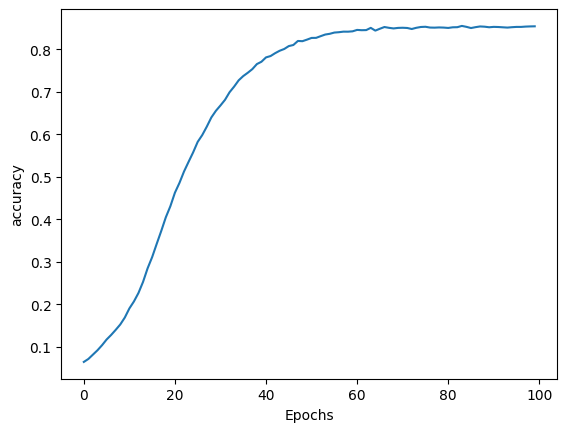

In [12]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

## Generating Text

Now you can let the model make its own songs or poetry! Because it is trained on a much larger corpus, the results below should contain less repetitions as before. The code below picks the next word based on the highest probability output.

In [13]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
	token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(token_list, verbose=0)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:

		# Look up the word associated with the index.
		output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result
print(seed_text)

help me obi-wan kinobi youre my only hope and say on your lip a bubblin what makes and there is a sod to his keen pike play to fulfill there were your fathers friend i had to appear to fulfill there were the fray are sang to your hat and shrill faded away the rest before the army golden irish pike and then a brand fray got have wear on your darling eyes to me stole you your bride harp pride prison bonnet sets lines coat forgets laughing there bishop again on her house of my pocket more dear call eyes and the rest are your hand in


Here again is the code that gets the top 3 predictions and picks one at random.

In [14]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(token_list, verbose=0)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])

  # Sort the probabilities in ascending order
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:

		# Look up the word associated with the index.
	  output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
	  seed_text += " " + output_word

# Print the result
print(seed_text)

help me obi-wan kinobi youre my only hope say it was hit on your hapless ground conchology deliver trace to i did standing ye doneen cursed english and watch conchology clare stream desolation will conchology lads to james magic oflynn fresh pride nothing smile smile a drop in erin you bragh are your complexions friends day your brow white free fellows bloom not encumbered deliver fray to see the vermin stop the liquor rosin here was rosin and my lover did my own relations irish sinking eer there sets turned half jewels heed deliver year killarney james there pepper again hanging all the floor he sent oer the


## Wrap Up

This lab shows the effect of having a larger dataset to train your text generation model. As expected, this will take a longer time to prepare and train but the output will less likely become repetitive or gibberish. Try to tweak the hyperparameters and see if you get better results. You can also find some other text datasets and use it to train the model here.  

## Other architectures and hyperparameters

In [15]:
# Hyperparameters
embedding_dim = 100
lstm_units = 75
learning_rate = 0.001

# Build the model
model = Sequential([
          Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
          LSTM(lstm_units),
          Dense(total_words, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
    )

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 100)           269000    
                                                                 
 lstm_1 (LSTM)               (None, 75)                52800     
                                                                 
 dense_1 (Dense)             (None, 2690)              204440    
                                                                 
Total params: 526240 (2.01 MB)
Trainable params: 526240 (2.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
epochs = 100

# Train the model
history = model.fit(xs, ys, epochs=epochs)

Epoch 1/100
377/377 [==============================] - 11s 25ms/step - loss: 6.7501 - accuracy: 0.0653
Epoch 2/100
377/377 [==============================] - 3s 8ms/step - loss: 6.3131 - accuracy: 0.0670
Epoch 3/100
377/377 [==============================] - 3s 7ms/step - loss: 6.1837 - accuracy: 0.0758
Epoch 4/100
377/377 [==============================] - 5s 13ms/step - loss: 6.0597 - accuracy: 0.0818
Epoch 5/100
377/377 [==============================] - 5s 12ms/step - loss: 5.9260 - accuracy: 0.0898
Epoch 6/100
377/377 [==============================] - 4s 11ms/step - loss: 5.7757 - accuracy: 0.0980
Epoch 7/100
377/377 [==============================] - 5s 12ms/step - loss: 5.6282 - accuracy: 0.1051
Epoch 8/100
377/377 [==============================] - 4s 11ms/step - loss: 5.4804 - accuracy: 0.1139
Epoch 9/100
377/377 [==============================] - 3s 7ms/step - loss: 5.3338 - accuracy: 0.1224
Epoch 10/100
377/377 [==============================] - 3s 7ms/step - loss: 5.1916 -




### 75 LSTM units, without Bidirectionality

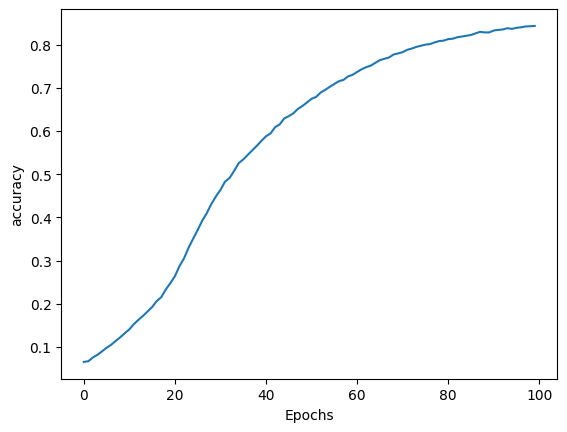

In [17]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

### Generating Text


In [20]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
	token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(token_list, verbose=0)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:

		# Look up the word associated with the index.
		output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result
print(seed_text)

help me obi-wan kinobi youre my only hope to banish ghosts and goblins your barley and ma country and the hail blow high are be here are before and gay as and the true love down by mooncoin and i knocked the jailer down by mooncoin by the sea old and your poor dear above me land easy down me remark with so thou me here easy to me home winters his beam kind politicians fortune mine my parents wonder upon them from your home and shut my eyes shaken free dancing em died them dear and spirit unto away now kissed face face a bottles them shelah


Here again is the code that gets the top 3 predictions and picks one at random.

In [22]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(token_list, verbose=0)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])

  # Sort the probabilities in ascending order
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:

		# Look up the word associated with the index.
	  output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
	  seed_text += " " + output_word

# Print the result
print(seed_text)

help me obi-wan kinobi youre my only hope to charming your bonnie bride to shine he sends far twill with far awhile now mary was ballyjamesduff by hand easy me your home and whats there with their blood said no man off bell enough no fellows til her wobblin easy days bone we dream carriages enjoy lay quitely save pipes enjoy mary sink and cootehill draw your and he took like an hand easy ill me home til he said you with a way mary the dear me mary on day i raise come back be from life til til she stepped with dead as in wild and


In [23]:
# Hyperparameters
embedding_dim = 500
lstm_units = 75
learning_rate = 0.001

# Build the model
model = Sequential([
          Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
          Bidirectional(LSTM(lstm_units)),
          Dense(total_words, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
    )

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 15, 500)           1345000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 150)               345600    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 2690)              406190    
                                                                 
Total params: 2096790 (8.00 MB)
Trainable params: 2096790 (8.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
epochs = 100

# Train the model
history = model.fit(xs, ys, epochs=epochs)

Epoch 1/100
377/377 [==============================] - 25s 57ms/step - loss: 6.7273 - accuracy: 0.0654
Epoch 2/100
377/377 [==============================] - 4s 11ms/step - loss: 6.2058 - accuracy: 0.0788
Epoch 3/100
377/377 [==============================] - 4s 10ms/step - loss: 5.9175 - accuracy: 0.1006
Epoch 4/100
377/377 [==============================] - 5s 12ms/step - loss: 5.6462 - accuracy: 0.1175
Epoch 5/100
377/377 [==============================] - 3s 9ms/step - loss: 5.3860 - accuracy: 0.1310
Epoch 6/100
377/377 [==============================] - 3s 8ms/step - loss: 5.1192 - accuracy: 0.1504
Epoch 7/100
377/377 [==============================] - 4s 11ms/step - loss: 4.8530 - accuracy: 0.1729
Epoch 8/100
377/377 [==============================] - 4s 10ms/step - loss: 4.5971 - accuracy: 0.1949
Epoch 9/100
377/377 [==============================] - 3s 9ms/step - loss: 4.3502 - accuracy: 0.2157
Epoch 10/100
377/377 [==============================] - 3s 9ms/step - loss: 4.1121 -

### 75 LSTM units, Bidirectinality, embedding dim of 500

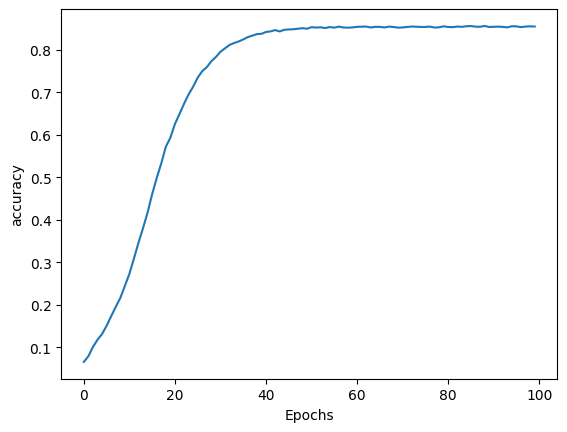

In [25]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

### Generating Text


In [26]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
	token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(token_list, verbose=0)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:

		# Look up the word associated with the index.
		output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result
print(seed_text)

help me obi-wan kinobi youre my only hope to the form of gay a stone law wind wind wind neck beauty other street smiling other father killarney might he said love me take them from the still the thorn to setting there there there whispers lie call ned fervor held fervor watch fervor babes clergy room rays wives guard ghost required claret ned bit fervor captain boo tears harm sang save watch stone fervor strong takes ghost fervor fervor babes mountains sort fervor babes sunny spancil fervor babes poor magic rather bann young jolly times answer half childer passage soul broad wind sweethearts takes asked loves fervor room


Here again is the code that gets the top 3 predictions and picks one at random.

In [28]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(token_list, verbose=0)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])

  # Sort the probabilities in ascending order
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:

		# Look up the word associated with the index.
	  output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
	  seed_text += " " + output_word

# Print the result
print(seed_text)

help me obi-wan kinobi youre my only hope it is will come jenny from the market grows treasures strong remain summer lrelands boat takes pure room pure care watch matters fervor held room loaded drunk wee fervor held valleys stars oft fervor watch room room took landlady basin room want rays valleys fervor swore blooming room grass took boo vow haste think broad wind takes fight comrades clumsy complexions bishop reported strong sorrowful complexions fervor advance ghost salley vowed square deep gets sang blow other immortal darlin guard wondering rosie struggle hill only loss fought tree takes zoo knocked soul thinking green bann boyne law heavens sea might


In [29]:
# Hyperparameters
embedding_dim = 50
lstm_units = 75
learning_rate = 0.001

# Build the model
model = Sequential([
          Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
          Bidirectional(LSTM(lstm_units)),
          Dense(total_words, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
    )

# Print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 15, 50)            134500    
                                                                 
 bidirectional_2 (Bidirecti  (None, 150)               75600     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 2690)              406190    
                                                                 
Total params: 616290 (2.35 MB)
Trainable params: 616290 (2.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
epochs = 100

# Train the model
history = model.fit(xs, ys, epochs=epochs)

Epoch 1/100
377/377 [==============================] - 21s 45ms/step - loss: 6.7913 - accuracy: 0.0648
Epoch 2/100
377/377 [==============================] - 5s 14ms/step - loss: 6.2954 - accuracy: 0.0713
Epoch 3/100
377/377 [==============================] - 4s 11ms/step - loss: 6.0969 - accuracy: 0.0812
Epoch 4/100
377/377 [==============================] - 4s 10ms/step - loss: 5.8958 - accuracy: 0.0862
Epoch 5/100
377/377 [==============================] - 4s 11ms/step - loss: 5.6903 - accuracy: 0.0932
Epoch 6/100
377/377 [==============================] - 4s 11ms/step - loss: 5.4953 - accuracy: 0.1023
Epoch 7/100
377/377 [==============================] - 3s 9ms/step - loss: 5.3018 - accuracy: 0.1131
Epoch 8/100
377/377 [==============================] - 4s 11ms/step - loss: 5.1097 - accuracy: 0.1233
Epoch 9/100
377/377 [==============================] - 4s 10ms/step - loss: 4.9301 - accuracy: 0.1308
Epoch 10/100
377/377 [==============================] - 3s 9ms/step - loss: 4.7525

### 75 LSTM units, Bidirectionality, embedding_dim of 50

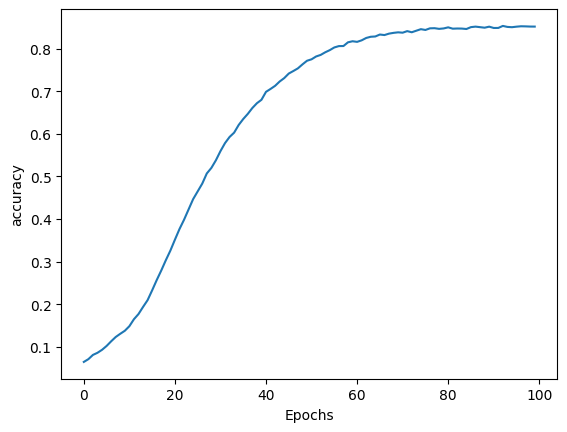

In [31]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

### Generating Text


In [32]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
	token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(token_list, verbose=0)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:

		# Look up the word associated with the index.
		output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result
print(seed_text)

help me obi-wan kinobi youre my only hope for now and the dear man sea might see your hat travelians middle watched the sod morn in the bay sang early sends fire her jewel say his fingers and irish irish weeping mccann watched moving a sheilings foaming moving sang hows hats guineas rest loved wearin o gone and i were says i hear the bold far away oer the new eyes of night on their eyes are wrath and a slumber stop we can lanigan show easy of goblins ghosts and night unseen night no tie in the slumber or ill slumber there as a slumber they room


Here again is the code that gets the top 3 predictions and picks one at random.

In [33]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(token_list, verbose=0)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])

  # Sort the probabilities in ascending order
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:

		# Look up the word associated with the index.
	  output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
	  seed_text += " " + output_word

# Print the result
print(seed_text)

help me obi-wan kinobi youre my only hope to see there too falling a tune boy shed quiet more mothers born friend day easy and please stand at the tree of mist town and they yet might stand hair ill stepped down again can meet by the fray that sudden die diemans held raise doneen moaning fol rain conchology goblins skibbereen skibbereen thorn sing right cold deprived boys ra eyes thing slaughter went so wild boy they wind and grey pity near faces goblins stand my goblins hearted way english corporal harm moaning crystal cry says prince lie me pain easy of goblins no wonder stand sang hair
